# Inputting ABM outputs into PV ICE 

## Import libraries and create test folder

In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
testfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'TEMP')
baselinesfolder =  str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
# Another option using relative address; for some operative systems you might need '/' instead of '\'
# testfolder = os.path.abspath(r'..\..\PV_ICE\TEMP')  

print ("Your simulation will be stored in %s" % testfolder)
print(baselinesfolder)

Your simulation will be stored in C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\TEMP
C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\baselines


## Create simulation

In [3]:
#create simulation
r1 = PV_ICE.Simulation(name='ABM_Simulation', path=testfolder)
#create 10 scenarios in simulation: 1st is standard in PV ICE, 2-10 are scenarios a-i in ABM
SCENARIOS = ['standard_PVICE','landfill_ban','high_mat_recovery_cheap_recycling','cheap_recycling','high_landfill_costs','better_lifetime','better_learning','reuse_warranties','seeding_reuse','juliens_baseline']
for myscenario in SCENARIOS:
    r1.createScenario(name=myscenario, file=r'..\baselines\baseline_modules_US.csv')
    r1.scenario[myscenario].addMaterial('glass', file=r'..\baselines\baseline_material_glass.csv')
    r1.scenario[myscenario].addMaterial('aluminium_frames', file=r'..\baselines\baseline_material_aluminium_frames.csv')
    r1.scenario[myscenario].addMaterial('silver', file=r'..\baselines\baseline_material_silver.csv')
    r1.scenario[myscenario].addMaterial('silicon', file=r'..\baselines\baseline_material_silicon.csv')
    r1.scenario[myscenario].addMaterial('copper', file=r'..\baselines\baseline_material_copper.csv')

path = C:\Users\ahegedus\Documents\GitHub\PV_ICE\PV_ICE\TEMP


## Modify Parameters

In [4]:
#modify values of each scenario 2-10 based on ABM outputs
#first, set 'mod_EOL_collected_recycled' to 100% in scenarios 2-10 for years 2022 on (assume all collected materials are recycled)
ABM_SCENARIOS = SCENARIOS[1:] 
past_years_collected_recycled = [r1.scenario['standard_PVICE'].data['mod_EOL_collected_recycled'][0]]*(2022-1995)
new_collected_recycled = [100]*(2050-2021)
#create new list to replace 'mod_EOL_collected_recycled' with, with 1995-2021 original baseline module values, and 2022-2050 at 100%
new_mod_recycled = past_years_collected_recycled + new_collected_recycled
for myscenario in ABM_SCENARIOS:
    r1.scenario[myscenario].data['mod_EOL_collected_recycled'] = new_mod_recycled

#next, modify 3 additional inputs for each scenario 2-10, with values depending on the scenario, coming from ABM outputs
MODIFIED_MODULE_BASELINES = ['mod_Repairing','mod_Repowering','mod_EOL_collection_eff']
len(r1.scenario['landfill_ban'].data['mod_Repairing']) #all inputs have 56 rows
#keep first 27 rows corresponding to 1995-2021 values
ABM_outputs = pd.read_csv(r'..\baselines\ABM\abm_outputs_mass_fractions.csv')

In [5]:
#ABM_outputs
#change scenario names to names from ABM_SCENARIOS
file_scenario_names = ABM_outputs['Scenario'].unique().tolist()
ABM_outputs = ABM_outputs.replace(file_scenario_names, ABM_SCENARIOS)

In [6]:
#changing repaired module baseline ('mod_Repairing') in landfill_ban scenario
landfill_ban_outputs = ABM_outputs.query('Scenario == "landfill_ban"') #filter by row
landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_repaired_milliontonnes'] #filter by column
#change new_mod_Repairing from fraction to percent and add onto 1995-2021 original mod_Repairing values
frames = [r1.scenario['landfill_ban'].data['mod_Repairing'][0:27],landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_repaired_milliontonnes']*100]
new_mod_Repairing = pd.concat(frames)
r1.scenario['landfill_ban'].data['mod_Repairing'] = new_mod_Repairing.values #replace values with new ones

In [7]:
#changing recycling module baseline ('mod_EOL_collection_eff') in landfill ban scenario
frames = [r1.scenario['landfill_ban'].data['mod_EOL_collection_eff'][0:27],landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_recycled_milliontonnes']*100]
new_mod_Recycling = pd.concat(frames)
r1.scenario['landfill_ban'].data['mod_EOL_collection_eff'] = new_mod_Recycling.values#replace values with new ones

In [8]:
#changing reuse module baseline ('mod_Repowering') in landfill ban scenario
frames = [r1.scenario['landfill_ban'].data['mod_Repowering'][0:27],landfill_ban_outputs.loc[2:,'mass_fraction_PV_materials_reused_milliontonnes']*100]
new_mod_Reuse = pd.concat(frames)
r1.scenario['landfill_ban'].data['mod_Repowering'] = new_mod_Reuse.values#replace values with new ones

In [9]:
#repeat for all other ABM scenarios
for myscenario in ABM_SCENARIOS[1:]:
    frames1 = []
    frames2 = []
    frames3 = []
    new_outputs = []
    scenario_filter = []
    new_mod_Repairing = []
    new_mod_Recycling = []
    new_mod_Reuse = []
    scenario_filter = 'Scenario == ' + '\"' + myscenario + '\"'
    new_outputs = ABM_outputs.query(scenario_filter)
    #replace repairing baselines
    repairs = new_outputs.loc[:,'mass_fraction_PV_materials_repaired_milliontonnes']*100
    repairs.index = list(range(31))
    frames1 = [r1.scenario[myscenario].data['mod_Repairing'][0:27],repairs[2:]]
    new_mod_Repairing = pd.concat(frames1)
    r1.scenario[myscenario].data['mod_Repairing'] = new_mod_Repairing.values
    #replace recycling baselines
    recycles = new_outputs.loc[:,'mass_fraction_PV_materials_recycled_milliontonnes']*100
    recycles.index = list(range(31))
    frames2 = [r1.scenario[myscenario].data['mod_EOL_collection_eff'][0:27],recycles[2:]]
    new_mod_Recycling = pd.concat(frames2)
    r1.scenario[myscenario].data['mod_EOL_collection_eff'] = new_mod_Recycling.values
    #replace reuse baselines
    reuses = new_outputs.loc[:,'mass_fraction_PV_materials_reused_milliontonnes']*100
    reuses.index = list(range(31))
    frames3 = [r1.scenario[myscenario].data['mod_Repowering'][0:27],reuses[2:]]
    new_mod_Reuse = pd.concat(frames3)
    r1.scenario[myscenario].data['mod_Repowering'] = new_mod_Reuse.values
    print(myscenario)

high_mat_recovery_cheap_recycling
cheap_recycling
high_landfill_costs
better_lifetime
better_learning
reuse_warranties
seeding_reuse
juliens_baseline


### Now all of the parameters are properly modified!

## Run Mass Flow Calculations

In [15]:
r1.calculateMassFlow()

Working on Scenario:  standard_PVICE
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  landfill_ban
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  high_mat_recovery_cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
Working on Scenario:  cheap_recycling
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
=

## Initial plotting of results

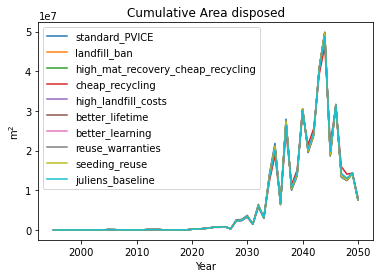

In [16]:
r1.plotScenariosComparison(keyword='Cumulative_Area_disposed')

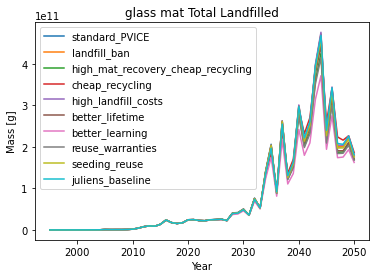

In [17]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

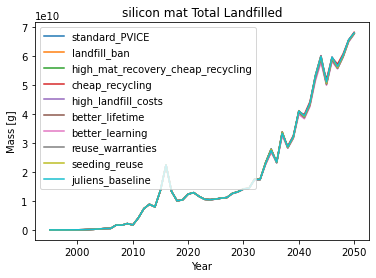

In [18]:
r1.plotMaterialComparisonAcrossScenarios(material='silicon', keyword='mat_Total_Landfilled')

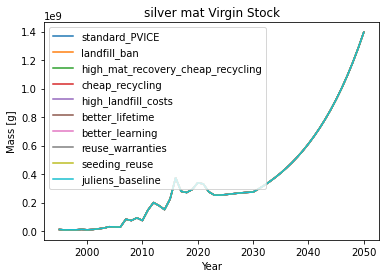

In [21]:
r1.plotMaterialComparisonAcrossScenarios(material='silver', keyword='mat_Virgin_Stock') #all the same values?

### Creating a summary of results in a new data frame

In [26]:
USyearly=pd.DataFrame()

In [27]:
keyword='mat_Virgin_Stock'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["VirginStock_"+material+'_'+r1.name+'_'+case] = foo[material]
        filter_col = [col for col in USyearly if (col.startswith('VirginStock') and col.endswith(r1.name+'_'+case)) ]
        USyearly['VirginStock_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)


In [28]:
keyword='mat_Total_Landfilled'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["Waste_"+material+'_'+r1.name+'_'+case] = foo[material]
        filter_col = [col for col in USyearly if (col.startswith('Waste') and col.endswith(r1.name+'_'+case)) ]
        USyearly['Waste_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)

In [29]:
keyword='mat_Total_EOL_Landfilled'
materials = ['glass', 'aluminium_frames','silicon', 'silver', 'copper']

# Loop over Scenarios
for jj in range(0, len(r1.scenario)): #goes from 0 to 9
    case = list(r1.scenario.keys())[jj]
    for ii in range (0, len(materials)):    
        material = materials[ii]
        foo = r1.scenario[case].material[material].materialdata[keyword].copy()
        foo = foo.to_frame(name=material)
        USyearly["Waste_EOL_"+material+'_'+r1.name+'_'+case] = foo[material]
        filter_col = [col for col in USyearly if (col.startswith('Waste_EOL') and col.endswith(r1.name+'_'+case)) ]
        USyearly['Waste_EOL_Module_'+r1.name+'_'+case] = USyearly[filter_col].sum(axis=1)

In [30]:
USyearly = USyearly/1000000  #Convert to metric tonnes
#907185 -- this is for US tons

In [31]:
keyword='new_Installed_Capacity_[MW]'

newcolname = keyword+'_'+r1.name
    
if newcolname in USyearly:
    USyearly[newcolname] = USyearly[newcolname]+r1.scenario[list(r1.scenario.keys())[0]].data[keyword]
else:
    USyearly[keyword+'_'+r1.name] = r1.scenario[list(r1.scenario.keys())[0]].data[keyword]

In [40]:
UScum = USyearly.copy()
UScum = UScum.cumsum()

,VirginStock_glass_ABM_Simulation_standard_PVICE,VirginStock_Module_ABM_Simulation_standard_PVICE,VirginStock_aluminium_frames_ABM_Simulation_standard_PVICE,VirginStock_silicon_ABM_Simulation_standard_PVICE,VirginStock_silver_ABM_Simulation_standard_PVICE,VirginStock_copper_ABM_Simulation_standard_PVICE,VirginStock_glass_ABM_Simulation_landfill_ban,VirginStock_Module_ABM_Simulation_landfill_ban,VirginStock_aluminium_frames_ABM_Simulation_landfill_ban,VirginStock_silicon_ABM_Simulation_landfill_ban,...,Waste_EOL_silicon_ABM_Simulation_seeding_reuse,Waste_EOL_silver_ABM_Simulation_seeding_reuse,Waste_EOL_copper_ABM_Simulation_seeding_reuse,Waste_EOL_glass_ABM_Simulation_juliens_baseline,Waste_EOL_Module_ABM_Simulation_juliens_baseline,Waste_EOL_aluminium_frames_ABM_Simulation_juliens_baseline,Waste_EOL_silicon_ABM_Simulation_juliens_baseline,Waste_EOL_silver_ABM_Simulation_juliens_baseline,Waste_EOL_copper_ABM_Simulation_juliens_baseline,new_Installed_Capacity_[MW]_ABM_Simulation
year,,,,,,,,,,,,,,,,,,,,,
1995,858.816756,6087.252312,312.916411,173.147230,10.735207,0.590784,858.816756,6087.252312,312.916411,173.147230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.500000
1996,1512.576922,10689.944851,545.434301,302.368298,18.588818,1.040508,1512.576922,10689.944851,545.434301,302.368298,...,0.000720,0.000075,0.000005,0.006705,0.046165,0.002581,0.000720,0.000075,0.000005,22.167667
1997,2287.512319,16019.828764,792.055185,452.477204,27.520702,1.573415,2287.512319,16019.828764,792.055185,452.477204,...,0.014242,0.001490,0.000091,0.132763,0.913864,0.051064,0.014242,0.001490,0.000091,33.789667
1998,3062.222703,21279.893109,1024.021962,599.479998,36.072700,2.106354,3062.222703,21279.893109,1024.021962,599.479998,...,0.094414,0.009867,0.000605,0.881379,6.064147,0.338417,0.094414,0.009867,0.000605,45.570667
1999,4157.451197,28673.317219,1344.756440,802.972184,47.629499,2.859925,4157.451197,28673.317219,1344.756440,802.972184,...,0.380763,0.039746,0.002444,3.558537,24.474712,1.364451,0.380763,0.039746,0.002444,62.455333


In [65]:
keyword='Installed_Capacity_[W]'

# Loop over Scenarios
for i in range(0, len(r1.scenario)):
    case = list(r1.scenario.keys())[i]
    foo = r1.scenario[case].data[keyword]
    foo = foo.to_frame(name=keyword)
    UScum["Capacity_"+r1.name+'_'+case] = foo[keyword].values #this needs to be .values

In [66]:
USyearly.index = r1.scenario['standard_PVICE'].data['year']
UScum.index = r1.scenario['standard_PVICE'].data['year']

In [68]:
USyearly.to_csv('ABM_Yearly_Results.csv')
UScum.to_csv('ABM_Cumulative_Results.csv')

### Plotting with USyearly and UScum data frames

<ipython-input-69-707bcb3e413a>:90: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a1.set_xticks(ind, ('S1', 'S2'))


Cumulative Virgin Needs by 2050 Million Tones by Scenario


0    90.255644
1    90.251122
dtype: float64

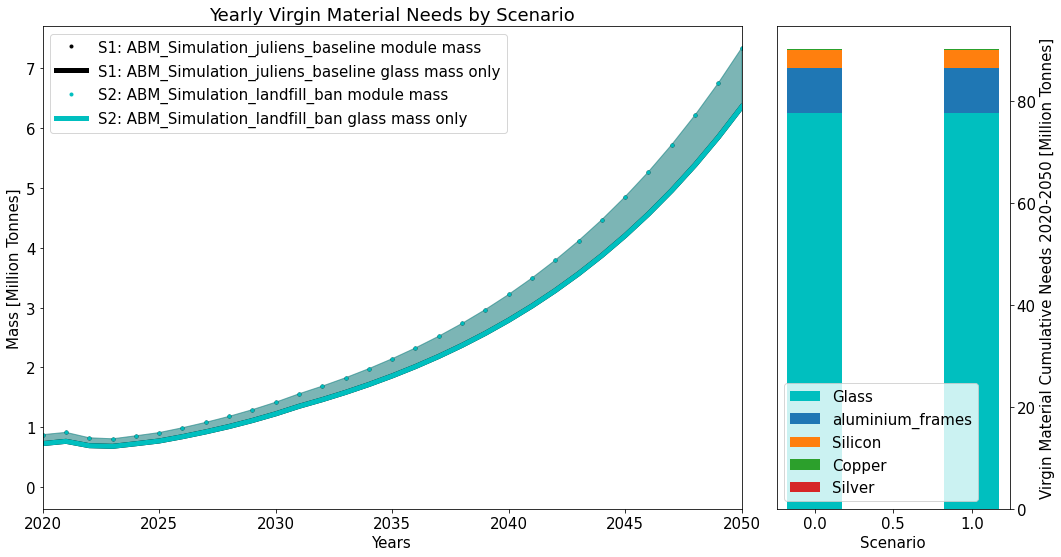

In [69]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='VirginStock_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames']


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
   
########################    
# SUBPLOT 1
########################
#######################
    
    
# Loop over scenarios
name0 = 'ABM_Simulation_juliens_baseline'
name2 = 'ABM_Simulation_landfill_ban'


# SCENARIO 1 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name0]+USyearly[keyw+materials[1]+'_'+name0]+
            USyearly[keyw+materials[2]+'_'+name0]+USyearly[keyw+materials[3]+'_'+name0]+
            USyearly[keyw+materials[4]+'_'+name0])
glassmat = (USyearly[keyw+materials[0]+'_'+name0])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'k.', linewidth=5, label='S1: '+name0+' module mass')
a0.plot(USyearly.index, glassmat, 'k', linewidth=5, label='S1: '+name0+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name2]+USyearly[keyw+materials[1]+'_'+name2]+
            USyearly[keyw+materials[2]+'_'+name2]+USyearly[keyw+materials[3]+'_'+name2]+
            USyearly[keyw+materials[4]+'_'+name2])
glassmat = (USyearly[keyw+materials[0]+'_'+name2])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'c.', linewidth=5, label='S2: '+name2+' module mass')
a0.plot(USyearly.index, glassmat, 'c', linewidth=5, label='S2: '+name2+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly Virgin Material Needs by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([2020, 2050])
a0.set_xlabel('Years')

##same values for yearly virgin material demand?! something went wrong.....?
########################    
# SUBPLOT 2
########################
#######################
# Calculate    

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    matcum.append(UScum[keyw+materials[ii]+'_'+name0].loc[2050])
    matcum.append(UScum[keyw+materials[ii]+'_'+name2].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminium_frames']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(2)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminium_frames'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Virgin Material Cumulative Needs 2020-2050 [Million Tonnes]')
a1.set_xlabel('Scenario')
a1.set_xticks(ind, ('S1', 'S2'))
#plt.yticks(np.arange(0, 81, 10))
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0] ), ('Glass', 'aluminium_frames', 'Silicon','Copper','Silver'))

f.tight_layout()

print("Cumulative Virgin Needs by 2050 Million Tones by Scenario")
dfcumulations2050[['glass','silicon','silver','copper','aluminium_frames']].sum(axis=1)

<ipython-input-52-73f9a6f197b3>:88: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a1.set_xticks(ind, ('S1', 'S2'))


Cumulative Waste by EoL 2050 Million Tones by Scenario


0    3.844055
1    3.867751
dtype: float64

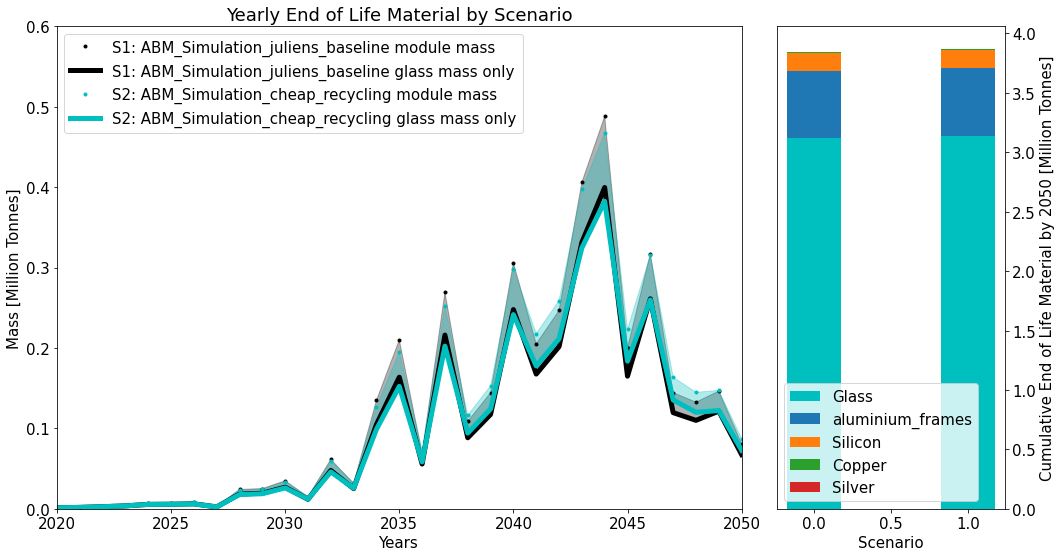

In [52]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)
keyw='Waste_EOL_'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminium_frames']


f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
#######################
   
# Loop over CASES
name0 = 'ABM_Simulation_juliens_baseline'
name2 = 'ABM_Simulation_cheap_recycling'

# SCENARIO 1 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name0]+USyearly[keyw+materials[1]+'_'+name0]+
            USyearly[keyw+materials[2]+'_'+name0]+USyearly[keyw+materials[3]+'_'+name0]+
            USyearly[keyw+materials[4]+'_'+name0])
glassmat = (USyearly[keyw+materials[0]+'_'+name0])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'k.', linewidth=5, label='S1: '+name0+' module mass')
a0.plot(USyearly.index, glassmat, 'k', linewidth=5, label='S1: '+name0+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='k', alpha=0.3,
                 interpolate=True)

# SCENARIO 2 ***************
modulemat = (USyearly[keyw+materials[0]+'_'+name2]+USyearly[keyw+materials[1]+'_'+name2]+
            USyearly[keyw+materials[2]+'_'+name2]+USyearly[keyw+materials[3]+'_'+name2]+
            USyearly[keyw+materials[4]+'_'+name2])
glassmat = (USyearly[keyw+materials[0]+'_'+name2])
modulemat = modulemat/1000000
glassmat = glassmat/1000000 
a0.plot(USyearly.index, modulemat, 'c.', linewidth=5, label='S2: '+name2+' module mass')
a0.plot(USyearly.index, glassmat, 'c', linewidth=5, label='S2: '+name2+' glass mass only')
a0.fill_between(USyearly.index, glassmat, modulemat, color='c', alpha=0.3,
                 interpolate=True)

a0.legend()
a0.set_title('Yearly End of Life Material by Scenario')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([2020, 2050])
a0.set_xlabel('Years')
a0.set_ylim([0, 0.6])

########################    
# SUBPLOT 2
########################
#######################
# Calculate    

cumulations2050 = {}
for ii in range(0, len(materials)):
    matcum = []
    matcum.append(UScum[keyw+materials[ii]+'_'+name0].loc[2050])
    matcum.append(UScum[keyw+materials[ii]+'_'+name2].loc[2050])
    cumulations2050[materials[ii]] = matcum

dfcumulations2050 = pd.DataFrame.from_dict(cumulations2050) 
dfcumulations2050 = dfcumulations2050/1000000   # in Million Tonnes

dfcumulations2050['bottom1'] = dfcumulations2050['glass']
dfcumulations2050['bottom2'] = dfcumulations2050['bottom1']+dfcumulations2050['aluminium_frames']
dfcumulations2050['bottom3'] = dfcumulations2050['bottom2']+dfcumulations2050['silicon']
dfcumulations2050['bottom4'] = dfcumulations2050['bottom3']+dfcumulations2050['copper']


## Plot BARS Stuff
ind=np.arange(2)
width=0.35 # width of the bars.
p0 = a1.bar(ind, dfcumulations2050['glass'], width, color='c')
p1 = a1.bar(ind, dfcumulations2050['aluminium_frames'], width,
             bottom=dfcumulations2050['bottom1'])
p2 = a1.bar(ind, dfcumulations2050['silicon'], width,
             bottom=dfcumulations2050['bottom2'])
p3 = a1.bar(ind, dfcumulations2050['copper'], width,
             bottom=dfcumulations2050['bottom3'])
p4 = a1.bar(ind, dfcumulations2050['silver'], width,
             bottom=dfcumulations2050['bottom4'])

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('Cumulative End of Life Material by 2050 [Million Tonnes]')
a1.set_xlabel('Scenario')
a1.set_xticks(ind, ('S1', 'S2'))
#plt.yticks(np.arange(0, 81, 10))
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0] ), ('Glass', 'aluminium_frames', 'Silicon','Copper','Silver'))

f.tight_layout()

print("Cumulative Waste by EoL 2050 Million Tones by Scenario")
dfcumulations2050[['glass','silicon','silver','copper','aluminium_frames']].sum(axis=1)